# 13.3. Confidence Intervals

We have developed a method for estimating a parameter by using random sampling and the bootstrap. Our method produces an interval of estimates, to account for chance variability in the random sample. By providing an interval of estimates instead of just one estimate, we give ourselves some wiggle room.


In [2]:
path_data = "../../data/"

from datascience import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline   

In [3]:
births = Table.read_table(path_data + 'baby.csv')
births.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


In [4]:
ratios = births.select('Birth Weight', 'Gestational Days').with_columns(
    'Ratio BW:GD', births.column('Birth Weight')/births.column('Gestational Days')
)
ratios.show(3)

Birth Weight,Gestational Days,Ratio BW:GD
120,284,0.422535
113,282,0.400709
128,279,0.458781


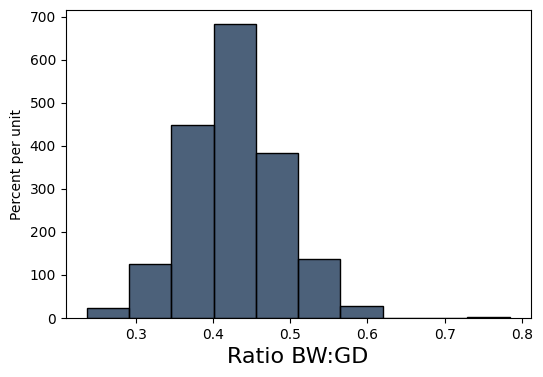

In [5]:
ratios.select('Ratio BW:GD').hist()  ### select() creates a copy of a "table" with only the selected columns

In [6]:
ratios.show(2)

Birth Weight,Gestational Days,Ratio BW:GD
120,284,0.422535
113,282,0.400709


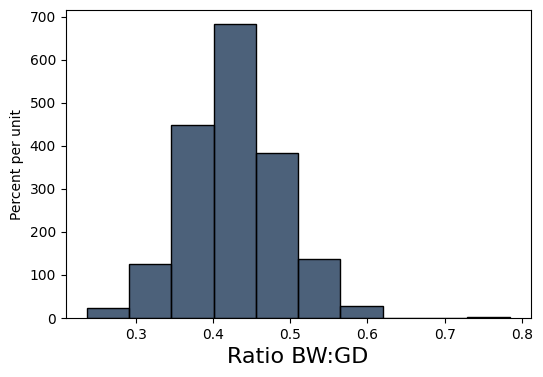

In [7]:
ratios.hist('Ratio BW:GD')

In [8]:
ratios.sort('Ratio BW:GD', descending=True).show(5)

Birth Weight,Gestational Days,Ratio BW:GD
116,148,0.783784
174,281,0.619217
174,284,0.612676
110,181,0.607735
174,288,0.604167


In [9]:
ratios.sort('Ratio BW:GD', descending=True).take(0)   ### take function Returns a copy of the table with only the specified rows included.

Birth Weight,Gestational Days,Ratio BW:GD
116,148,0.783784


In [10]:
ratios.sort('Ratio BW:GD', descending=True).take(0)[2][0]   ### you were thinking

0.78378378378378377

In [11]:
ratios.sort('Ratio BW:GD', descending=True).show(1)

Birth Weight,Gestational Days,Ratio BW:GD
116,148,0.783784


In [12]:
### the numpy.take() function returns elements from array along the mentioned axis and indices

In [13]:
array = np.arange(10)
array

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [14]:
array.reshape(2, 5)

array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]])

In [15]:
array = [[5, 6, 2, 7, 1], 
         [4, 9, 2, 9, 3]]

In [16]:
print(array)

[[5, 6, 2, 7, 1], [4, 9, 2, 9, 3]]


In [17]:
print(np.take(array, [0, 4]))

[5 1]


In [18]:
## The median gives a sense of the typical ratio because it is unaffected 
## by the very large or very small ratios. The median ratio in the sample 
## is about 0.429 ounces per day.

percentile(50, ratios.column(2))
## a good estimation, lucky to have (for a population)

0.42907801418439717

##### back to weight/days

But what was the median in the population? We don’t know, so we will estimate it.

Our method will be exactly the same as in the previous section. We will bootstrap the sample 5,000 times resulting in 5,000 estimates of the median. Our 95% confidence interval will be the “middle 95%” of all of our estimates.

## 13.3.1.1. Constructing a Bootstrap Confidence Interval

We will start by defining a function one_bootstrap_median. It will bootstrap the sample and return one the median ratio in the bootstrapped sample.

In [19]:
def one_bootstrap_median():
    resample = ratios.sample()     ### default: n, with replacement true, 
    return percentile(50, resample.column('Ratio BW:GD'))

In [20]:
ratios.show(5)

Birth Weight,Gestational Days,Ratio BW:GD
120,284,0.422535
113,282,0.400709
128,279,0.458781
108,282,0.382979
136,286,0.475524


In [21]:
## Run the cell below to see how the bootstrapped ratios vary. 
## Remember that each of them is an estimate of the unknown ratio in the population.

one_bootstrap_median()

0.42413793103448277

In [22]:
## Now we can use a for loop to generate 5000 bootstrapped medians.

num_repetitions = 5000
bootstrap_medians = make_array()
for i in np.arange(num_repetitions):
    bootstrap_medians=np.append(
        bootstrap_medians, one_bootstrap_median()
    )

In [23]:
## The results
bootstrap_medians

array([ 0.42857143,  0.42753623,  0.42857143, ...,  0.42753623,
        0.43060498,  0.43010753])

In [24]:
# Get the endpoints of the 95% confidence interval

left = percentile(2.5, bootstrap_medians)
right = percentile(97.5, bootstrap_medians)
make_array(left, right)

array([ 0.42537313,  0.43262411])

The **95% confidence interval** goes from about 0.425 ounces per day to about 0.433 ounces per day. We are **estimating** the **median “birth weight to gestational days” ratio** in the population is somewhere in the interval 0.425 ounces per day to 0.433 ounces per day.

The estimate of 0.429 based on the original sample happens to be half-way in between the two ends of the interval, though that need not be true in general.

To visualize our results, let us draw the empirical histogram of our bootstrapped medians and place the confidence interval on the horizontal axis.

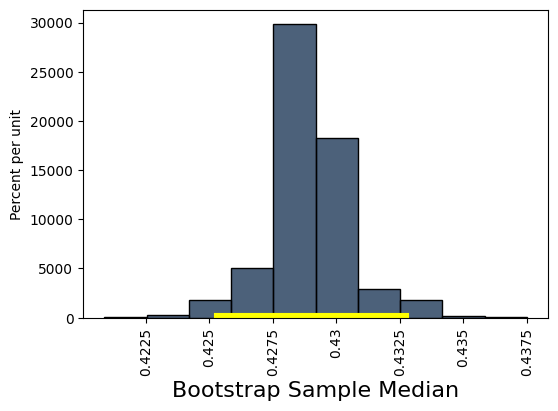

In [25]:

resampled_medians = Table().with_columns(            ### make the array back to table for visualization
    'Bootstrap Sample Median', bootstrap_medians
)

resampled_medians.hist()

plt.plot([left, right], [0, 0], color='yellow', lw=8);


## 13.3.2. Estimating a Population Average

What we have done for medians can be done for averages as well. Suppose we want to estimate the average age of the mothers in the population. A natural estimate is the average age of the mothers in the sample. Here is the distribution of their ages, and their average age which was about 27.2 years.



In [26]:
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


- What's the age of all the mothers in the population? There's no way of knowing (?) but
- we may use the **average age** of the mothers in our sample as an estimate. 

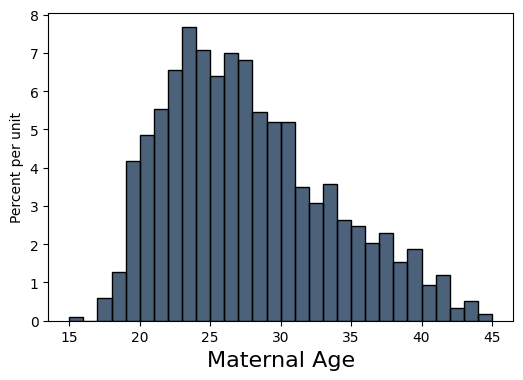

In [27]:
### let's take a look at the age distribution of all the mothes 

# births.select('Maternal Age').hist()
births.select('Maternal Age').hist(bins=30)   ### bins

In [28]:
# np.mean(births.column('Maternal Age'))
# births.column('Maternal Age').mean()

np.average(births.column('Maternal Age'))

27.228279386712096

- We do not have access to the average age of the mothers (a parameter) in the **population**.
- Use bootstrap to estimate the **parameter**.

Let’s estimate the unknown parameter by the **bootstrap method**. To do this, we will adapt the code for bootstrap_median to instead define the function bootstrap_mean. The code is the same except that the statistics are means (that is, averages) instead of medians, and are collected in an array called bstrap_means instead of bstrap_medians.

In [29]:
### one simulation

def one_bootstrao_mean():
    resample = births.sample()     ##### returns table; default: n, replacement=True
    return np.average(resample.column('Maternal Age'))   ### return average of sample mean

In [30]:
### repeat

repetitions = 5000
bootstrap_means = make_array()

for i in np.arange(repetitions):
    bootstrap_means = np.append(
        bootstrap_means, one_bootstrao_mean()
    )

In [31]:
bootstrap_means

array([ 27.16524702,  27.52044293,  27.19931857, ...,  27.31345826,
        27.29131175,  27.31005111])

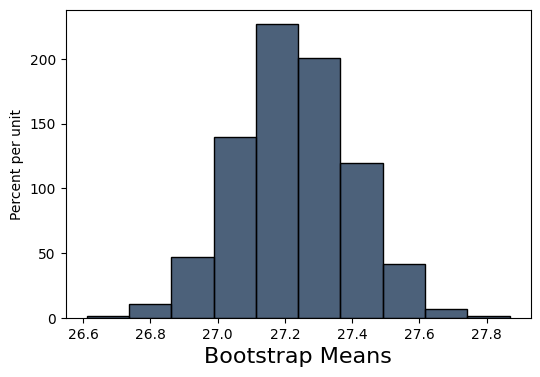

In [32]:
bootstrap_means_tbl = Table().with_column(
    "Bootstrap Means", bootstrap_means)
bootstrap_means_tbl.hist()

In [33]:
### now do the 95% interval

left = percentile (2.5, bootstrap_means)
right = percentile(97.5, bootstrap_means)
make_array(left, right)
### this gives us the 95% confidence interval 

array([ 26.89267462,  27.55792164])

#### we "estimate" the **AVERAGE** age of the population to be in between the interval 

Notice how close the two ends are to the average of about 27.2 years in the original sample. The sample size is very large – 1,174 mothers – and so the sample averages don’t vary much. We will explore this observation further in the next chapter.

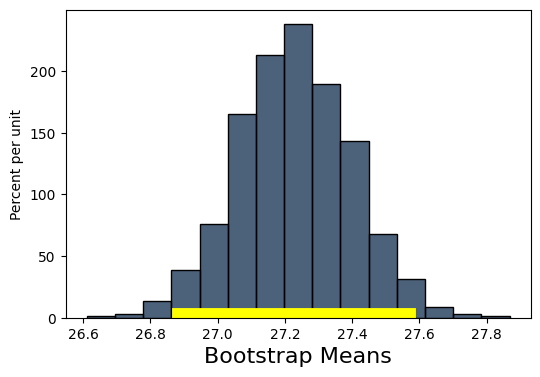

In [34]:
bootstrap_means_tbl.hist(bins = 15)
plt.plot([left, right], [0,0], color='Yellow', lw=15)

Once again, the average of the original sample (27.23 years) is close to the center of the interval. That’s not very surprising, because each bootstrapped sample is drawn from that same original sample. The averages of the bootstrapped samples are about symmetrically distributed on either side of the average of the sample from which they were drawn.

Notice also that the empirical histogram of the resampled means has roughly a symmetric bell shape, even though the histogram of the sampled ages was not symmetric at all:

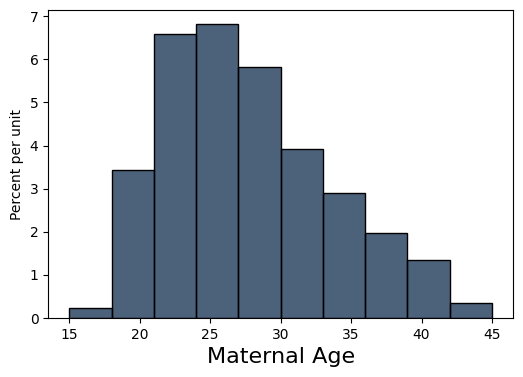

In [35]:
### compare this shape to the original age histogram

births.select('Maternal Age').hist()

This is a consequence of the **Central Limit Theorem** of probability and statistics. In later sections, we will see what the theorem says.

In [36]:
### why the re-sampled distribution does not resemble the original distribution?
### Central Limit Theorem of probability and statistics

## 13.3.3. An 80% Confidence Interval
You can use the bootstrapped sample means to construct an interval of any level of confidence. For example, to construct an 80% confidence interval for the mean age in the population, you would take the “middle 80%” of the resampled means. So you would want 10% of the distribution in each of the two tails, and hence the endpoints would be the 10th and 90th percentiles of the resampled means.

- a confidence interval (CI) is an interval which is expected to typically **contain the parameter** being estimated.

- specifically, given a confidence level γ% (95% and 99% are typical values), a CI is a random interval which contains the parameter being estimated γ% of the time. ==> % of time, the parameter will be between the two ends.

- just to show you the flexibility of CI

In [37]:
left_80 = percentile(10, bootstrap_means)
right_80 = percentile(90, bootstrap_means)
make_array(left_80, right_80)

array([ 27.01703578,  27.44122658])

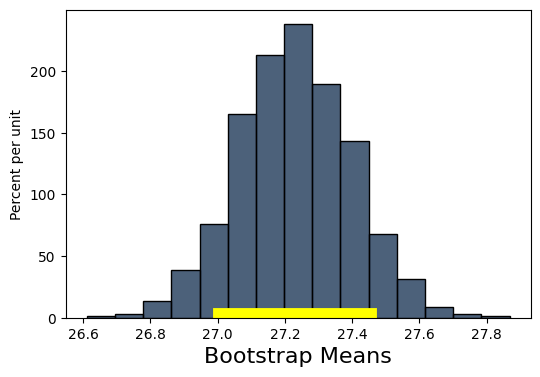

In [38]:
bootstrap_means_tbl.hist(bins = 15)
plt.plot([left_80, right_80], [0,0], color="yellow", lw=15)

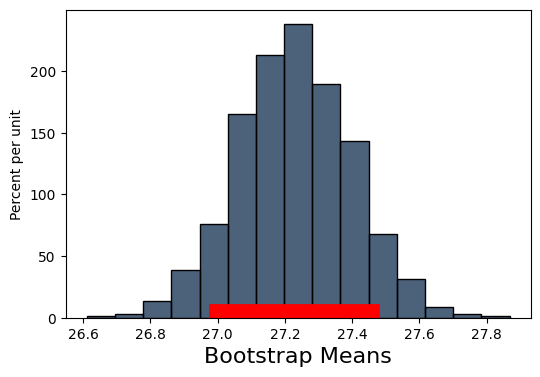

In [39]:
bootstrap_means_tbl.hist(bins = 15)
plt.plot((left_80, right_80), (0,0), color="red", lw=20)

## 13.3.4. Estimating a Population Proportion

In [40]:
### percentage of maternal smoking
births.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


In [41]:
births.where(
    'Maternal Smoker', are.equal_to(True)
).num_rows / births.num_rows

0.3909710391822828

In [42]:
smoking = births.column('Maternal Smoker')
np.count_nonzero(smoking) / len(smoking)

0.3909710391822828

In [43]:
def one_bootstrap_proportion():
    resample = births.sample()
    smoking = resample.column('Maternal Smoker')
    return np.count_nonzero(smoking) / len(smoking)

In [44]:
repetitions = 5000
bootstrap_proportions = make_array()
for i in np.arange(repetitions):
    bootstrap_proportions = np.append(
        bootstrap_proportions, one_bootstrap_proportion()
    )

In [45]:
bootstrap_proportions_tbl = Table().with_column(
    'Bootstrap Proportion', bootstrap_proportions)

In [46]:
left_p = percentile(2.5, bootstrap_proportions)
right_p = percentile(97.5, bootstrap_proportions)
make_array(left_p, right_p)

array([ 0.36286201,  0.41908007])

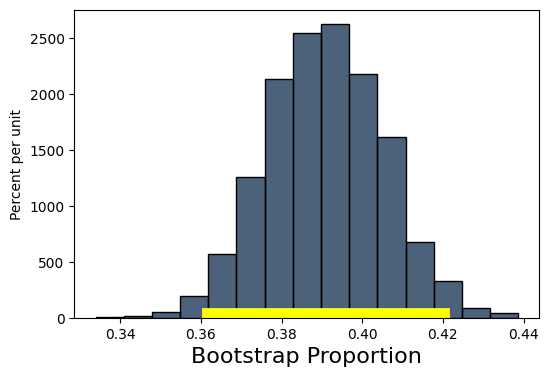

In [47]:
bootstrap_proportions_tbl.hist(bins=15)

plt.plot((left_p, right_p), [0,0], color="yellow", lw= 15)

## 13.3.5. Care in Using the Bootstrap Percentile Method

he bootstrap is an elegant and powerful method. Before using it, it is important to keep some points in mind.

Start with a large random sample. If you don’t, the method might not work. Its success is based on large random samples (and hence also resamples from the sample) resembling the population. The Law of Averages says that this is likely to be true provided the random sample is large.

To approximate the probability distribution of a statistic, it is a good idea to replicate the resampling procedure as many times as possible. A few thousand replications will result in decent approximations to the distribution of sample median, especially if the distribution of the population has one peak and is fairly symmetric. We used 5,000 replications in our examples but would recommend 10,000 in general.

The bootstrap percentile method works well for estimating the population median or mean based on a large random sample. However, it has limitations, as do all methods of estimation. For example, it is not expected to do well in the following situations.

The goal is to estimate the minimum or maximum value in the population, or a very low or very high percentile, or parameters that are greatly influenced by rare elements of the population.

The probability distribution of the statistic is not roughly bell shaped.

The original sample is very small, say less than 10 or 15.

In [48]:
# births = Table.read_table(path_data + 'baby.csv')

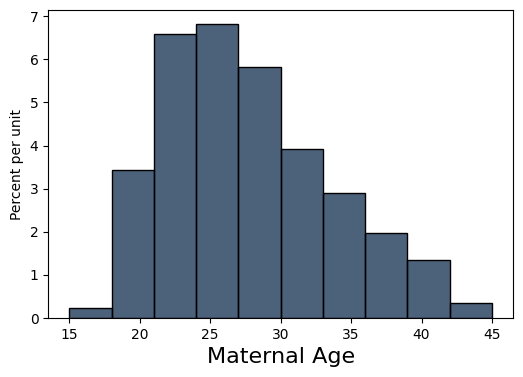

In [49]:
births.select('Maternal Age').hist()